<a href="https://colab.research.google.com/github/nbpyth97/Exercise/blob/master/tp1/ps2022_tp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processamento de Streams 2022
## TP1 - Air Quality Monitoring (airborne particulate matter)
-- version April 6 
 - updated to full dataset.

-- version April 8 
 - added code for spark streaming (unstructured)

-- version April 12
 - added a note to highlight the unstructured data
 format has the timestamp at the last position.




The goal of this project is to analyze data provided by a set of air quality sensors [sds011](https://aqicn.org/sensor/sds011/pt/). The sensors present in the dataset are located in Portugal, namely in the Lisbon metro area. Each sensor provides two values: measuring particles less than 10 µm (P1) and less than 2.5 µm (P2) in μg/m³.

The sensor data, spans the first half of 2020, and is streamed of Kafka. 

Each data sample has the following schema:

sensor_id | sensor_type | location | latitude | longitude | timestamp | P1 | P2
----------|-------------|----------|----------|-----------|-----------|----|---
string  | string | string | float | float| timestamp | float | float



## Questions


1. Find the time of day with the poorest air quality, for each location. Updated daily;
2. Find the average air quality, for each location. Updated hourly;
3. Can you show any daily and/or weekly patterns to air quality?;
4. The data covers a period of extensive population confinement due to Covid 19. Can you find a signal in the data showing air quality improvement coinciding with the confinement period?

## Requeriments

1. Solve each question using one of the systems studied in the course.
2. For questions not fully specified, provide your own interpretation, given your own analysis of the data.

## Grading Criteria 

1. Bonus marks will be given for solving questions using more than one system (eg. Spark Unstructured + Spark Structured);
2. Bonus marks will be given if some kind of graphical output is provided to present the results;
3. Grading will also take into account the general clarity of the programming and of the presentation report (notebook).




### Deadline

30th April + 1 day - ***no penalty***

For each day late, ***0.5 / day penalty***. Penalty accumulates until
the grade of the assignment reaches 8.0.

---
### Colab Setup


In [1]:
#@title Mount Google Drive (Optional)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title Install PySpark
!pip install pyspark findspark --quiet
import findspark
findspark.init()
findspark.find()

     |████████████████████████████████| 281.4 MB 31 kB/s 
     |████████████████████████████████| 198 kB 14.4 MB/s 


'/usr/local/lib/python3.7/dist-packages/pyspark'

In [ ]:
#@title Install & Launch Kafka
%%bash
KAFKA_VERSION=3.1.0
KAFKA=kafka_2.13-$KAFKA_VERSION
wget -q -O /tmp/$KAFKA.tgz https://dlcdn.apache.org/kafka/$KAFKA_VERSION/$KAFKA.tgz
tar xfz /tmp/$KAFKA.tgz
wget -q -O $KAFKA/config/server1.properties - https://github.com/smduarte/ps2022/raw/main/colab/server1.properties

UUID=`$KAFKA/bin/kafka-storage.sh random-uuid`
$KAFKA/bin/kafka-storage.sh format -t $UUID -c $KAFKA/config/server1.properties
$KAFKA/bin/kafka-server-start.sh -daemon $KAFKA/config/server1.properties


Formatting /tmp/kraft-combined-logs


### Air quality sensor data publisher
This a small python Kafka client that publishes a continous stream of text lines, obtained from the periodic output of the sensors.

* The Kafka server is accessible @localhost:9092 
* The events are published to the `air_quality` topic
* Events are published 3600x faster than realtime relative to the timestamp


In [3]:
#@title Start Kafka Publisher
%%bash
pip install kafka-python dataclasses --quiet
wget -q -O - https://github.com/smduarte/ps2022/raw/main/colab/kafka-tp1-logsender.tgz | tar xfz - 2> /dev/null

cd kafka-tp1-logsender
nohup python publisher.py --filename 2020-01-06_sds011-pt.csv --topic air_quality  --speedup 3600 2> publisher-error.log > publisher-out.log &

The python code below shows the basics needed to process JSON data from Kafka source using PySpark.

Spark Streaming python documentation is found [here](https://spark.apache.org/docs/latest/api/python/reference/pyspark.streaming.html)

---
#### PySpark Kafka Stream Example


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

def dumpBatchDF(df, epoch_id):
    df.show(5, False)

spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')


schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True),
                     StructField('p2', FloatType(), True)])

lines = lines.select( from_json(col('value'), schema).alias('data')).select('data.*')
#top5 = lines.groupBy(window(lines.timestamp, '24 seconds', '24 seconds'), 'location') \
#       .count()

query = lines \
    .writeStream \
    .outputMode('append') \
    .foreachBatch(dumpBatchDF) \
    .start()
query.awaitTermination(30)
query.stop()
spark.stop()

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

### Spark Streaming (UnStructured) 

Latest Spark does not support Kafka sources with UnStructured Streaming.

The next cell publishes the dataset using a TCP server, running at port 7777. For this mode, there is no need to install or run Kafka, using the cell above.

The events are played faster than "realtime", at a 3600x speedup, such that 1 hour in terms of dataset timestamps is
sent in 1 second realtime, provided the machine is fast enough. As such, Spark Streaming window functions need to be sized accordingly, since a minibatch of 1 second will be
worth 1 hour of dataset events.

In [4]:
%%bash

git clone https://github.com/smduarte/ps2022.git 2> /dev/null > /dev/null || git -C ps2022 pull
cd ps2022/colab/socket-tp1-logsender/

nohup python publisher.py --filename 2020-01-06_sds011-pt.csv --port 7777  --speedup 3600 2> /tmp/publisher-error.log > /tmp/publisher-out.log &

Each line sample has the following parts separated by blanks:

sensor_id | sensor_type | location | latitude | longitude | P1 | P2 | timestamp 
----------|-------------|----------|----------|-----------|-----------|----|---
string  | string | string | float | float| float | float | timestamp



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

lines = spark.readStream.format('socket') \
    .option('host', 'localhost') \
    .option('port', 7777) \
    .load()

sl = split(lines.value, ' ')

results = lines \
      .withColumn('sensor_id', sl.getItem(0).cast('string')) \
      .withColumn('sensor_type', sl.getItem(1).cast('string')) \
      .withColumn('location', sl.getItem(2).cast('string')) \
      .withColumn('latitude', sl.getItem(3).cast('float')) \
      .withColumn('longitude', sl.getItem(4).cast('float')) \
      .withColumn('P1', sl.getItem(5).cast('float')) \
      .withColumn('P2', sl.getItem(6).cast('float')) \
      .withColumn('timestamp', sl.getItem(7).cast('timestamp'))\
      .drop('value')

try:
  results = results \
            .withWatermark('timestamp', '1 seconds')\
            .groupBy('location', window( results.timestamp, '10 seconds', '10 seconds')) \
            .count().alias('count')\

  query = results \
    .writeStream \
    .outputMode('complete') \
    .foreachBatch(lambda df, epoch: df.show(10, False)) \
    .start()

  query.awaitTermination(20)
  query.stop()
except Exception as err:
  print(err)
  

+--------+------------------------------------------+-----+
|location|window                                    |count|
+--------+------------------------------------------+-----+
|14858   |{2020-01-14 02:37:40, 2020-01-14 02:37:50}|1    |
|13691   |{2020-01-11 08:55:35, 2020-01-11 08:55:45}|1    |
|13691   |{2020-01-03 17:45:00, 2020-01-03 17:45:10}|1    |
|19563   |{2020-01-12 23:45:35, 2020-01-12 23:45:45}|1    |
|14857   |{2020-01-06 17:15:30, 2020-01-06 17:15:40}|1    |
|2332    |{2020-01-03 05:32:00, 2020-01-03 05:32:10}|1    |
|19563   |{2020-01-02 17:31:30, 2020-01-02 17:31:40}|1    |
|13691   |{2020-01-03 22:56:30, 2020-01-03 22:56:40}|1    |
|13691   |{2020-01-10 01:16:30, 2020-01-10 01:16:40}|1    |
|10161   |{2020-01-10 15:15:40, 2020-01-10 15:15:50}|1    |
+--------+------------------------------------------+-----+
only showing top 10 rows

+--------+------------------------------------------+-----+
|location|window                                    |count|
+--------+----

ERROR:py4j.clientserver:There was an exception while executing the Python Proxy on the Python Side.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 581, in _call_proxy
    return_value = getattr(self.pool[obj_id], method)(*params)
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/utils.py", line 196, in call
    raise e
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/utils.py", line 193, in call
    self.func(DataFrame(jdf, self.sql_ctx), batch_id)
  File "<ipython-input-29-54338f2daaeb>", line 14, in <lambda>
    query = results     .writeStream     .outputMode('complete')     .foreachBatch(lambda df, epoch: df.show(10, False))     .start()
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/dataframe.py", line 502, in show
    print(self._jdf.showString(n, int_truncate, vertical))
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1322, in __call__
    answer, self.gateway

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext

import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

try:
  ssc = StreamingContext(spark.sparkContext,1)
  lines = ssc.socketTextStream('localhost', 7777)
  line = lines.window(1,1)

  results=line.filter(lambda x : len(x)>0)\
  .map(lambda x:('{}{}'.format(x.split(' ')[2],x.split(' ')[-1][8:10]),x.split(' ')[-3]))\
  .map(lambda x:((x[0]),x[1]))\
  .reduceByKey(lambda a,b: max(a+b))

  results.pprint()
    
  ssc.start()
  ssc.awaitTermination(5)
except Exception as err:
  print(err)
ssc.stop()
spark.stop()



An error occurred while calling o7128.awaitTerminationOrTimeout.
: org.apache.spark.SparkException: An exception was raised by Python:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pyspark/streaming/util.py", line 68, in call
    r = self.func(t, *rdds)
  File "/usr/local/lib/python3.7/dist-packages/pyspark/streaming/dstream.py", line 170, in takeAndPrint
    taken = rdd.take(num + 1)
  File "/usr/local/lib/python3.7/dist-packages/pyspark/rdd.py", line 1568, in take
    res = self.context.runJob(self, takeUpToNumLeft, p)
  File "/usr/local/lib/python3.7/dist-packages/pyspark/context.py", line 1227, in runJob
    sock_info = self._jvm.PythonRDD.runJob(self._jsc.sc(), mappedRDD._jrdd, partitions)
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1322, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/utils.py", line 111, in deco
    return f(*a, **

Find the average air quality, for each location. Updated hourly;

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext

spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()

try:
  ssc = StreamingContext(spark.sparkContext, 1)
  lines = ssc.socketTextStream('localhost', 7777) 

  results=lines.filter(lambda x : len(x)>0)\
  .map(lambda x:((x.split(' ')[2]+' '+x.split(' ')[-1][11:13]),(float(x.split(' ')[-3]),1)))\
  .reduceByKey(lambda x, y: (x[0]+y[0], x[1]+y[1]))\
  .map(lambda x : (x[0],x[1][0]/x[1][1]))

  results.pprint()
    
  ssc.start()
  ssc.awaitTermination(5)
except Exception as err:
  print(err)
ssc.stop()
spark.stop()

-------------------------------------------
Time: 2022-04-28 22:04:47
-------------------------------------------

-------------------------------------------
Time: 2022-04-28 22:04:48
-------------------------------------------
('13691 00', 28.824400000000004)
('14857 00', 178.77695652173915)
('14858 01', 229.77)
('10161 00', 117.895)
('14858 00', 263.3808695652174)
('2332 00', 549.0566666666666)
('14857 01', 129.47)

-------------------------------------------
Time: 2022-04-28 22:04:49
-------------------------------------------
('14858 01', 212.37227272727276)
('2332 01', 412.6426086956522)
('10161 01', 101.8625)
('13691 01', 23.940833333333334)
('14857 01', 110.07318181818181)
('10161 02', 76.43)

-------------------------------------------
Time: 2022-04-28 22:04:50
-------------------------------------------
('13691 02', 21.760833333333338)
('13691 03', 12.6)
('2332 02', 314.77149999999995)
('14857 02', 73.19250000000001)
('14858 02', 157.10095238095238)
('10161 02', 75.2133333333

Can you show any daily and/or weekly patterns to air quality?

-------------------------------------------
Time: 2022-04-29 19:39:57
-------------------------------------------
('13691', '01', 40.73)
('13691', '01', 44.43)
('13691', '01', 42.53)
('13691', '01', 43.9)
('13691', '01', 42.57)
('13691', '01', 40.9)
('13691', '01', 42.97)
('13691', '01', 39.1)
('13691', '01', 35.63)
('13691', '01', 37.1)
...



No handles with labels found to put in legend.


-------------------------------------------
Time: 2022-04-29 19:40:21
-------------------------------------------
('13691', '02', 16.87)
('13691', '02', 16.6)
('13691', '02', 15.53)
('13691', '02', 16.13)
('13691', '02', 18.2)
('13691', '02', 17.57)
('13691', '02', 14.3)
('13691', '02', 15.47)
('13691', '02', 15.7)
('13691', '02', 15.3)
...



No handles with labels found to put in legend.


-------------------------------------------
Time: 2022-04-29 19:40:45
-------------------------------------------
('13691', '03', 14.9)
('13691', '03', 18.27)
('13691', '03', 16.53)
('13691', '03', 16.6)
('13691', '03', 14.87)
('13691', '03', 15.73)
('13691', '03', 14.6)
('13691', '03', 16.2)
('13691', '03', 15.57)
('13691', '03', 15.83)
...



No handles with labels found to put in legend.


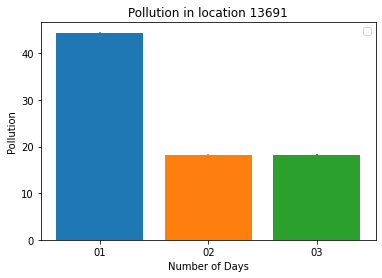

In [31]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.sql.types import StringType, StructField, StructType

import pandas as pd
import matplotlib.pyplot as plt

#location | timestamp | P1

spark = SparkSession \
    .builder \
    .appName('Kafka Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.1') \
    .getOrCreate()


def convert_to_df(rdd):
  try:
    df = spark.createDataFrame(rdd)
    df_pandas = df.toPandas()
    df_pandas.columns = ['location', 'timestamp', 'pollution']
    x = df_pandas['timestamp']
    y = df_pandas['pollution']
    plt.bar(x,y)
    plt.plot()
    plt.xlabel("Number of Days")
    plt.ylabel("Pollution")
    plt.title("Pollution in location 13691")
    plt.legend()

    for i in range

  except Exception as err:
    print(err) 

try:
  ssc = StreamingContext(spark.sparkContext, 1)
  lines = ssc.socketTextStream('localhost', 7777) 
  line = lines.window(1,24)

  results=line.filter(lambda x : len(x)>0)\
  .map(lambda x:(x.split(' ')[2],x.split(' ')[-1][8:10],float(x.split(' ')[-3])))\
  .filter(lambda x : x[0] == '13691')

  results.pprint()
  results.foreachRDD(convert_to_df)
    
  ssc.start()
  ssc.awaitTermination(72)

except Exception as err:
  print(err)
ssc.stop()
spark.stop()

Each line sample has the following parts separated by blanks:

sensor_id | sensor_type | location | latitude | longitude | P1 | P2 | timestamp 
----------|-------------|----------|----------|-----------|-----------|----|---
string  | string | string | float | float| float | float | timestamp

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, split, count
import pandas
import matplotlib.pyplot as plt


spark = SparkSession \
    .builder \
    .appName('StructuredWebLogExample') \
    .getOrCreate()

lines = spark.readStream.format('socket') \
    .option('host', 'localhost') \
    .option('port', 7777) \
    .load()
  
sl = split( lines.value, ' ')
table = lines \
      .withColumn('sensor_id', sl.getItem(0).cast('string'))\
      .withColumn('sensor_type', sl.getItem(1).cast('string'))\
      .withColumn('location', sl.getItem(2).cast('string'))\
      .withColumn('latitude', sl.getItem(3).cast('float'))\
      .withColumn('longitude', sl.getItem(4).cast('float'))\
      .withColumn('P1', sl.getItem(5).cast('float'))\
      .withColumn('P2', sl.getItem(6).cast('float'))\
      .withColumn('timestamp', sl.getItem(7).cast('timestamp'))\
      .drop('value')
try:

  results = table \
            .groupBy('location') \
            .count()

except Exception as err:
  print(err)

'''
x = results.select('timestamp').toList()
y = results.select('P2').toList()
plt.bar(x,y)
plt.show()
'''

query = results \
    .writeStream \
    .outputMode('complete') \
    .trigger(processingTime='1 seconds') \
    .foreachBatch(lambda df, epoch: df.show(10, False)) \
    .start()

query.awaitTermination(5)
query.stop()